In [1]:
import os
SLURM_PATH = '/home/yandex/MLWG2025/amitr5'
CACHE_DIR = f'{SLURM_PATH}/tmp/hf_cache' 

if SLURM_PATH in os.getcwd():
        os.makedirs(CACHE_DIR, exist_ok=True)
        os.environ["PIP_PATH"] = f"{SLURM_PATH}/BaryGNN/anaconda3/envs/conf/bin/pip"
        os.environ["TEMP_DIR"] = CACHE_DIR
        os.environ["HF_HOME"] = CACHE_DIR
        os.environ["TRANSFORMERS_CACHE"] = CACHE_DIR
        os.environ["HF_DATASETS_CACHE"] = CACHE_DIR
        # Hugging Face uses HUGGINGFACE_HUB_CACHE (HF_HUB_CACHE is ignored)
        os.environ["HUGGINGFACE_HUB_CACHE"] = CACHE_DIR
        os.environ["TMPDIR"] = CACHE_DIR
        os.environ["XDG_CACHE_HOME"] = CACHE_DIR
        # os.environ["TOKENIZERS_PARALLELISM"] = "false"


# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"

In [1]:
# Imports #
import numpy as np
from transformers import Qwen3VLForConditionalGeneration, AutoProcessor, AutoModelForSeq2SeqLM, AutoTokenizer
import torch
import os
import pandas as pd
# from datasets import load_dataset
# import torch.nn.functional as F
from tqdm.auto import tqdm
# Project imports #

import utils
from mind2web.dataloader import build_datasets_dict, subsample_by_annotation ,MultiChoiceDataset
from utils import CACHE_DIR
from utils import log_response
# sys.path.append('./Mind2Web/src')

In [2]:
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-xl", cache_dir=CACHE_DIR)
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "osunlp/MindAct_ActionPrediction_flan-t5-xl"

# model = AutoModelForSeq2SeqLM.from_pretrained(model_name, cache_dir=CACHE_DIR, device_map="auto")
# model.eval();

In [ ]:
utils.reload('mind2web.dataloader')
id2split = MultiChoiceDataset.id2split
ds_dict = build_datasets_dict(id2split.values(),cache_dir=CACHE_DIR);

mind2web.dataloader- reloaded


Resolving data files:   0%|          | 0/27 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/27 [00:00<?, ?it/s]

Parameter 'function'=<function get_data_split.<locals>.get_score at 0x778fae5d6b60> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only shown once. Subsequent hashing failures won't be shown.


Map:   0%|          | 0/4060 [00:00<?, ? examples/s]

In [ ]:
utils.reload('mind2web.dataloader')
from mind2web.dataloader import subsample_by_annotation, MultiChoiceDataset
cal_dict, test_dict = {}, {}
seed = 42
frac = 0.1
num_candidates=5
max_context_len=512

for split, ds in ds_dict.items():
    flattened = ds_dict[split]
    cal_set, test_set = subsample_by_annotation(flattened, frac=frac, seed=seed)
    cal_dict[split] = MultiChoiceDataset(
        cal_set, tokenizer, num_candidates=num_candidates, max_context_len=max_context_len, cache_prompt=True, cache_tokenized=True
    )
    test_dict[split] = MultiChoiceDataset(
        test_set, tokenizer, num_candidates=num_candidates, max_context_len=max_context_len,cache_prompt=True, cache_tokenized=True
    )

mind2web.dataloader- reloaded


In [6]:
# cal_df = utils.llm.run_evaluation(cal_dict, model, tokenizer)
# cal_df.to_pickle("cal_results.pkl")
cal_df = pd.read_pickle("cal_results.pkl")
test_df = pd.read_pickle("test_results.pkl")
# cal_df.head()

cal_df['correct'] = cal_df['pred_label'] == cal_df['label']
# probability of the true label
cal_df['true_prob'] = cal_df.apply(lambda row: row['choices_probs'][row['label']] if row['label'] in row['choices_probs'] else 0, axis=1)



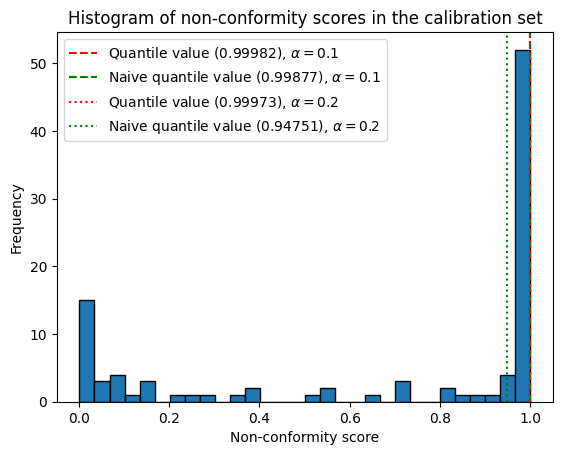

A good predictor should have low non-conformity scores, concentrated at the left side of the figure
Split (𝛼=0.1): test_task - Threshold: 0.9999, Naive Threshold: 0.9093
Split (𝛼=0.1): test_domain - Threshold: 0.9998, Naive Threshold: 0.9991
Split (𝛼=0.1): test_website - Threshold: 0.9999, Naive Threshold: 0.9988


In [7]:
def get_threshold(scores, alpha: float):
    N = len(scores)
    k = int(np.ceil((N + 1) * (1 - alpha)))
    sorted_scores = np.sort(scores.values)
    threshold = sorted_scores[k - 1]
    return threshold

# google's nonconformity score
cal_grouped = cal_df.groupby('annotation_id')
score_per_group = 1 - cal_grouped['true_prob'].min()

threshold = get_threshold(score_per_group, alpha=0.1)

naive_threshold = get_threshold(1 - cal_df['true_prob'], alpha=0.1)
naive_threshold2 = get_threshold(1 - cal_df['true_prob'], alpha=0.2)
threshold2 = get_threshold(score_per_group, alpha=0.2)

# plot histogram of non-conformity scores in the calibration set
utils.plot.nonconformity_histogram(
    score_per_group, threshold, naive_threshold, threshold2, naive_threshold2
)

cal_grouped_test_split = cal_df.groupby('test_split')
for split_name, group in cal_grouped_test_split:
    score_per_group = 1 - group.groupby('annotation_id')['true_prob'].min()
    threshold_ = get_threshold(score_per_group, alpha=0.1)
    naive_threshold = get_threshold(1 - group['true_prob'], alpha=0.1)
    print(f"Split (𝛼=0.1): {idx_split_map[split_name]} - Threshold: {threshold_:.4f}, Naive Threshold: {naive_threshold:.4f}")

cal_grouped = cal_df.groupby('annotation_id')
score_per_group = 1 - cal_grouped['true_prob'].min()
threshold = get_threshold(score_per_group, alpha=0.1)

In [51]:
# Model is probably biased towards A when not certain
print(cal_df[cal_df['correct'] == False]['pred_label'].value_counts())
# utils.plot.accuracy_vs_length(cal_df);

pred_label
A    162
D      5
B      2
F      1
E      1
Name: count, dtype: int64


In [15]:
len(test_df[test_df['pred_set_size'] > 1]) / len(test_df)

0.9993102259010174

In [ ]:
test_df[test_df['pred_set_size']>1].iloc[1]

relative_idx                                                     1
annotation_id                 91695df8-f256-47c9-8c37-06e8d0fc758f
action_uid                    ea2865e4-2858-478c-bf83-93d576cad774
pred_label                                                       B
pred_action                                                  CLICK
pred_value                                                    None
label                                                            B
label_text                                       B.\nAction: CLICK
choices_probs    {'A': 0.0009128428064286709, 'B': 0.9990413784...
prob                                                      0.999041
test_split                                                       0
labels_tokens                                  B.\nAction: CLICK\n
correct                                                       True
pred_set                                                    [A, B]
pred_set_size                                                 

In [4]:
import pandas as pd
oracle_answers = pd.read_pickle('oracle_answers.pkl')
oracle_answers.head()

,idx,relative_idx,test_split,annotation_id,action_uid,oracle_answer
0,0,0,0,91695df8-f256-47c9-8c37-06e8d0fc758f,73e0e7ed-d784-4b7a-a06c-48324e44ce7b,Click the 'Reservations' button located at the...
1,1,1,0,91695df8-f256-47c9-8c37-06e8d0fc758f,ea2865e4-2858-478c-bf83-93d576cad774,"Click the ""Budget Truck"" link located at the t..."
2,2,2,0,91695df8-f256-47c9-8c37-06e8d0fc758f,c70a5d9b-8777-4ff7-a17d-1f76012e14ba,Type '08817' into the input field labeled 'Whe...
3,3,3,0,91695df8-f256-47c9-8c37-06e8d0fc758f,3e671043-cab2-4e44-a1ce-3ed9de91d16b,"Type ""04/12/2024"" into the input field labeled..."
4,4,4,0,91695df8-f256-47c9-8c37-06e8d0fc758f,60888ab2-b605-4886-8dac-6ba72b6cde0a,"Click the date ""12"" in the April 2023 calendar..."


[]

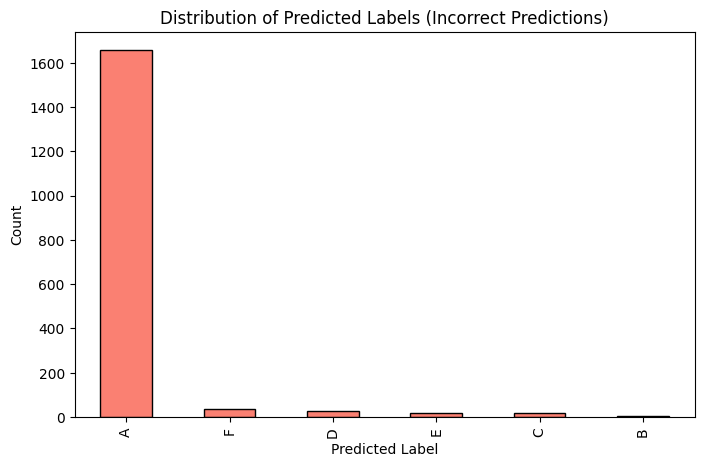

In [37]:
import matplotlib.pyplot as plt
# Filter for incorrect predictions and count values
df_all = pd.concat([cal_df, test_df], ignore_index=True)
incorrect_counts = df_all[df_all['correct'] == False]['pred_label'].value_counts()

# Create the bar plot
plt.figure(figsize=(8, 5))
incorrect_counts.plot(kind='bar', color='salmon', edgecolor='black')

plt.title('Distribution of Predicted Labels (Incorrect Predictions)')
plt.xlabel('Predicted Label')
plt.ylabel('Count')
plt.plot()

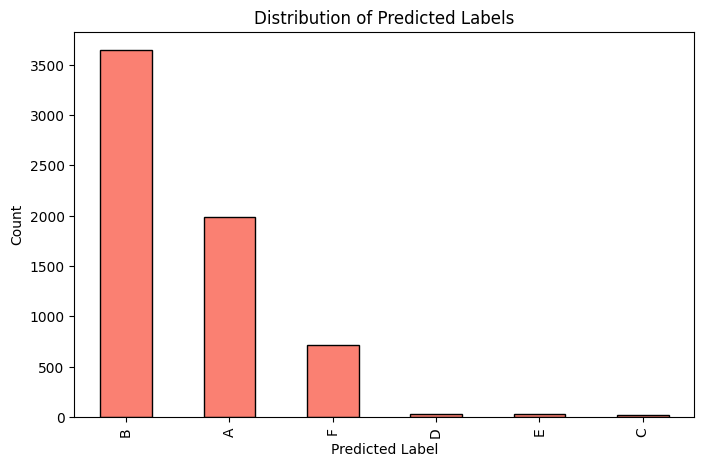

In [38]:
import matplotlib.pyplot as plt
# Filter for incorrect predictions and count values

incorrect_counts = df_all['pred_label'].value_counts()

# Create the bar plot
plt.figure(figsize=(8, 5))
incorrect_counts.plot(kind='bar', color='salmon', edgecolor='black')

plt.title('Distribution of Predicted Labels')
plt.xlabel('Predicted Label')
plt.ylabel('Count')
plt.show()

In [9]:
test_df['correct'] = test_df['pred_label'] == test_df['label']
test_df['pred_set'] = test_df['choices_probs'].apply(lambda row: [ label for label, prob in row.items() if 1 - prob <= threshold])
test_df['pred_set_size'] = test_df['pred_set'].apply(len)
# test_task_group = test_df.groupby('annotation_id')

In [11]:
import utils.metrics
def print_evaluation(df):
    for idx_split, split_name in idx_split_map.items():
        print(f"Metrics for split: {split_name}")
        print(utils.metrics.compute_mind2web_metrics(df, split_value=idx_split))
    print(f"Metrics for overall dataset:")
    print(utils.metrics.compute_mind2web_metrics(df))

df_all = pd.concat([cal_df, test_df], ignore_index=True)
print_evaluation(df_all)

Metrics for split: test_task
{'Ele. Acc': np.float64(82.46), 'Op. F1': np.float64(79.57), 'Step SR': np.float64(76.16), 'SR': np.float64(22.6)}
Metrics for split: test_domain
{'Ele. Acc': np.float64(72.82), 'Op. F1': np.float64(70.27), 'Step SR': np.float64(67.07), 'SR': np.float64(16.57)}
Metrics for split: test_website
{'Ele. Acc': np.float64(69.5), 'Op. F1': np.float64(67.01), 'Step SR': np.float64(62.39), 'SR': np.float64(8.45)}
Metrics for overall dataset:
{'Ele. Acc': np.float64(74.04), 'Op. F1': np.float64(71.44), 'Step SR': np.float64(68.0), 'SR': np.float64(16.49)}


In [12]:
df_orig_all = pd.concat([cal_df, df_orig], ignore_index=True)
print_evaluation(df_orig_all)

Metrics for split: test_task
{'Ele. Acc': np.float64(81.86), 'Op. F1': np.float64(78.81), 'Step SR': np.float64(75.32), 'SR': np.float64(22.6)}
Metrics for split: test_domain
{'Ele. Acc': np.float64(71.41), 'Op. F1': np.float64(68.98), 'Step SR': np.float64(65.84), 'SR': np.float64(17.72)}
Metrics for split: test_website
{'Ele. Acc': np.float64(66.46), 'Op. F1': np.float64(63.99), 'Step SR': np.float64(59.23), 'SR': np.float64(7.75)}
Metrics for overall dataset:
{'Ele. Acc': np.float64(72.55), 'Op. F1': np.float64(70.0), 'Step SR': np.float64(66.57), 'SR': np.float64(17.18)}


In [13]:
df_orig_all = pd.concat([cal_df, df_shift], ignore_index=True)
print_evaluation(df_orig_all)

Metrics for split: test_task
{'Ele. Acc': np.float64(81.58), 'Op. F1': np.float64(78.55), 'Step SR': np.float64(75.18), 'SR': np.float64(22.6)}
Metrics for split: test_domain
{'Ele. Acc': np.float64(71.47), 'Op. F1': np.float64(69.05), 'Step SR': np.float64(65.89), 'SR': np.float64(17.87)}
Metrics for split: test_website
{'Ele. Acc': np.float64(66.56), 'Op. F1': np.float64(64.08), 'Step SR': np.float64(59.26), 'SR': np.float64(7.75)}
Metrics for overall dataset:
{'Ele. Acc': np.float64(72.55), 'Op. F1': np.float64(70.01), 'Step SR': np.float64(66.59), 'SR': np.float64(17.28)}


In [11]:
# print("Evaluation on Test Set")
# print(f"Avg task accuracy: {test_df['correct'].mean():.4f}")
# print(f"Avg annotation accuracy: {test_task_group['correct'].min().mean():.4f}")
# utils.plot.accuracy_vs_length(test_df);


In [14]:
import gc
try:
    # Not enough memory for 2 models so we need to free GPU memory
    for d in set(model.hf_device_map.values()):
        if isinstance(d, int):
            torch.cuda.set_device(d)
            torch.cuda.empty_cache()
    del model
    gc.collect()         
    torch.cuda.empty_cache()       
    torch.cuda.ipc_collect()
except NameError:
    pass

try:
    # Not enough memory for 2 models so we need to free GPU memory
    for d in set(model.hf_device_map.values()):
        if isinstance(d, int):
            torch.cuda.set_device(d)
            torch.cuda.empty_cache()
    del oracle
    gc.collect()         
    torch.cuda.empty_cache()       
    torch.cuda.ipc_collect()
except NameError:
    pass

In [77]:
import gc
del oracle
gc.collect()         
torch.cuda.empty_cache()       
torch.cuda.ipc_collect()

In [172]:
from tqdm.auto import tqdm
def ask_oracle(df:pd.DataFrame):
    answers = []
    # iterrows is SLOW! should replace
    for i, target in tqdm(df.iterrows(), desc="Asking oracle..."):
        test_set = test_dict[idx_split_map[target['test_split']]]

        html_context, seq_in, seq_out, prev_actions, choices_str = test_set.prompt_view[target['relative_idx']]
        task = test_set.data[target['relative_idx']]['confirmed_task']
        screenshot = test_set.data[target['relative_idx']]['screenshot']
        
        answer=oracle.ask(task=task,
                prev_actions=prev_actions,
                html_context=html_context,
                choices=choices_str,
                candidates=target['pred_set'],
                image=screenshot)
        log_response(target["annotation_id"], target["action_uid"], answer)
        answers.append([i,target['relative_idx'], target['test_split'], target["annotation_id"],target["action_uid"], answer])
    answers_df = pd.DataFrame(answers, columns=['idx','relative_idx','test_split','annotation_id','action_uid','oracle_answer'])
    return answers_df

# answer_df = ask_oracle(test_df[test_df['pred_set_size'] > 1])
# answer_df.to_pickle("oracle_answers.pkl")


In [173]:
import gc
torch.cuda.empty_cache()
gc.collect()

2790

In [189]:
utils.reload('utils.prompts')
utils.reload('utils.llm_utils')

answer_df = pd.read_pickle("oracle_answers.pkl")  
re_eval_df = utils.llm.re_evaluate_with_oracle(test_dict, test_df[test_df['pred_set_size'] > 1], answer_df, model, tokenizer)
# re_eval_df = utils.llm.re_evaluate_with_oracle_batch(test_dict, test_df[test_df['pred_set_size'] > 1], answer_df, model, tokenizer, batch_size=2)
# re_eval_df.to_pickle("re_eval_results_23.pkl")
# re_eval_df.head()
# re_eval_results:
# 1 - $task $help together + choices elimination remapped
# 2 - $task $help seperated + choices elimination NOT remapped
# 3 - $task $help seperated + choices elimination remapped
# 4 - $task $help seperated + choices NO elimination NOT remapped
# 5 - (21) replacing $task with help
# 6 - (2_1) $task $help seperated + choices elimination NOT remapped (no html)
# 22 - $task $help seperated BUT help right after task + choices elimination NOT remapped 
# 23 - same as 22 but we remap choices


utils.prompts- reloaded
utils.llm_utils- reloaded


Re-evaluating with oracle...:   0%|          | 0/5646 [00:00<?, ?it/s]

<html> <body> <iframe fb:page facebook social plugin f22569b367eaa4> <div feed> <div> <div> <div id=0> Ticket Center </div> <a id=1> <span> about 6 years ago </span> </a> </div> <div id=2> <p id=3> Jeff Dunham is making everyone laugh with those puppets of his. Haven't seen him live yet? No worries... grab your </p> <a> http://www.ticketcenter.com//perfectly-unbalanced-jeff-du/ </a> </div> </div> </div> </iframe> <tr> <td> 22 </td> <td> 23 </td> <td id=4> 24 </td> <td> 25 </td> <td> 26 </td> <td> 27 </td> </tr> </body> </html>
Based on the HTML webpage above, try to complete the following task:
Task: Browse the venues that are playing the Wicked show from Oct 5 to Oct 24 2023
Guidence: Click the date cell labeled "24" in the calendar grid, which is located in the row with dates 22
Previous actions:
[textbox]  Search for artists, teams or venues... -> TYPE: Wicked
[option]  Wicked -> CLICK
[button]  All dates -> CLICK
[textbox]  Select Date Range -> CLICK
[columnheader]   -> CLICK
[col

In [149]:
# print(re_eval_df['choices_probs'][0])
x = pd.read_pickle("re_eval_results2.pkl")
# print(x['choices_probs'][0])
target = pd.read_pickle("re_eval_results_22.pkl")

target['correct'] = target['pred_label'] == target['label']
x['correct'] = x['pred_label'] == x['label']
target[(target['correct'] == False)&(x['correct'] == True)]

,relative_idx,annotation_id,action_uid,pred_label,pred_action,pred_value,label,label_text,choices_probs,prob,test_split,text_output,correct
30,30,9223f1b4-43ad-4636-9541-99ff9e6ad918,c21aa18b-a3e6-44f9-a068-9169f5483c81,A,None,None,F,F.\nAction: CLICK,"{'A': 0.7952436208724976, 'B': 0.0003522790793...",0.795244,0,A.,False
117,118,4b8fb0aa-7d7c-4a22-bfd5-f09316a050c3,660ffac3-80b3-47f2-ad88-9d1cd15878ec,F,CLICK,None,B,B.\nAction: CLICK,"{'A': 0.2755173146724701, 'B': 0.0211880579590...",0.700594,0,F. Action: CLICK,False
215,218,b674adf9-8950-4d27-b888-b789ccd49479,2b586b17-3cf1-4f01-9798-b597215a5598,A,None,None,B,B.\nAction: CLICK,"{'A': 0.5991392135620117, 'B': 0.3982783555984...",0.599139,0,A.,False
389,394,f9c80513-c1c2-42ef-b768-9a6d0bb5a9a5,817e114d-d315-4508-a57b-4b006463c3c4,A,None,None,B,B.\nAction: CLICK,"{'A': 0.555938184261322, 'B': 0.44406184554100...",0.555938,0,A.,False
537,546,e56ef366-a861-4d96-a1ad-8891d11a0950,ef210961-543a-41b8-ae8f-f07bf22a003e,A,None,None,B,B.\nAction: CLICK,"{'A': 0.6083258390426636, 'B': 0.3916741311550...",0.608326,0,A.,False
554,564,615b59c3-4bef-4d46-8df6-7224b22bd27c,6bcb3cae-6a2a-4eea-a1fd-430681a69a1a,A,None,None,F,F.\nAction: CLICK,"{'A': 0.6462556719779968, 'C': 0.0003972092235...",0.646256,0,A.,False
574,584,e617d6c6-28ee-46cf-965e-ee1448910ce8,88faa170-a068-4638-ab2f-bdf77b1da017,A,None,None,B,B.\nAction: CLICK,"{'A': 0.6038386225700378, 'B': 0.3935435116291...",0.603839,0,A.,False
618,632,a3f650df-02e8-409a-987c-3acddf0ad1f5,fea65442-e1a5-42ca-b204-4a6722123153,A,None,None,B,B.\nAction: CLICK,"{'A': 0.6726649403572083, 'B': 0.3273350894451...",0.672665,0,A.,False
744,760,610fe8c0-6598-4bd5-9864-8e41378db276,53780663-23c5-4f28-9187-0de5a4ff6156,A,None,None,B,B.\nAction: TYPE\nValue: Toyota Corolla,"{'A': 0.740839421749115, 'B': 0.25916051864624...",0.740839,0,A.,False
1202,21,f2cfae2c-fef2-423f-8b5e-eca6b4ec4c40,e4cd8c67-27f4-4632-94ed-781fdbc94750,A,None,None,B,B.\nAction: CLICK,"{'A': 0.5531144142150879, 'B': 0.4458695054054...",0.553114,1,A.,False


In [14]:
print_evaluation(test_df[test_df['pred_set_size'] > 1])
print("----"*5)
print_evaluation(test_df[test_df['pred_set_size'] == 1])


Metrics for split: test_task
{'Ele. Acc': np.float64(82.94), 'Op. F1': np.float64(80.39), 'Step SR': np.float64(76.99), 'SR': np.float64(24.38)}
Metrics for split: test_domain
{'Ele. Acc': np.float64(73.78), 'Op. F1': np.float64(71.23), 'Step SR': np.float64(68.08), 'SR': np.float64(18.88)}
Metrics for split: test_website
{'Ele. Acc': np.float64(70.29), 'Op. F1': np.float64(67.83), 'Step SR': np.float64(63.28), 'SR': np.float64(10.16)}
Metrics for overall dataset:
{'Ele. Acc': np.float64(74.9), 'Op. F1': np.float64(72.36), 'Step SR': np.float64(68.97), 'SR': np.float64(18.62)}
--------------------
Metrics for split: test_task
{'Ele. Acc': np.float64(55.56), 'Op. F1': np.float64(50.82), 'Step SR': np.float64(46.3), 'SR': np.float64(44.44)}
Metrics for split: test_domain
{'Ele. Acc': np.float64(46.94), 'Op. F1': np.float64(46.94), 'Step SR': np.float64(46.94), 'SR': np.float64(45.92)}
Metrics for split: test_website
{'Ele. Acc': np.float64(50.0), 'Op. F1': np.float64(50.0), 'Step SR': np

0       {'A': 0.02635188214480877, 'B': 0.973309397697...
1       {'A': 0.0030708236154168844, 'B': 0.9969292283...
2       {'A': 0.009036794304847717, 'B': 0.99096328020...
3       {'A': 0.017959782853722572, 'B': 0.98204022645...
4       {'A': 0.005839147605001926, 'B': 0.99409133195...
                              ...                        
5641    {'A': 0.029781188815832138, 'F': 0.9702188372612}
5642    {'A': 0.0051618702709674835, 'B': 0.9948380589...
5643    {'A': 0.018530014902353287, 'B': 0.98146992921...
5644    {'A': 0.9993777275085449, 'B': 0.0002468221646...
5645    {'A': 0.8898308277130127, 'B': 0.1011474952101...
Name: choices_probs, Length: 5646, dtype: object

----------
Metrics for split: test_task
{'Ele. Acc': np.float64(71.68), 'Op. F1': np.float64(78.55), 'Step SR': np.float64(66.01), 'SR': np.float64(18.75)}
Metrics for split: test_domain
{'Ele. Acc': np.float64(64.48), 'Op. F1': np.float64(68.91), 'Step SR': np.float64(59.38), 'SR': np.float64(13.44)}
Metrics for split: test_website
{'Ele. Acc': np.float64(55.48), 'Op. F1': np.float64(63.94), 'Step SR': np.float64(49.39), 'SR': np.float64(4.69)}
Metrics for overall dataset:
{'Ele. Acc': np.float64(64.48), 'Op. F1': np.float64(69.9), 'Step SR': np.float64(59.14), 'SR': np.float64(13.14)}
----------
Metrics for split: test_task
{'Ele. Acc': np.float64(81.62), 'Op. F1': np.float64(78.84), 'Step SR': np.float64(75.37), 'SR': np.float64(23.12)}
Metrics for split: test_domain
{'Ele. Acc': np.float64(71.19), 'Op. F1': np.float64(68.84), 'Step SR': np.float64(65.83), 'SR': np.float64(17.44)}
Metrics for split: test_website
{'Ele. Acc': np.float64(66.24), 'Op. F1': np.float64(63.84), 'Step SR':

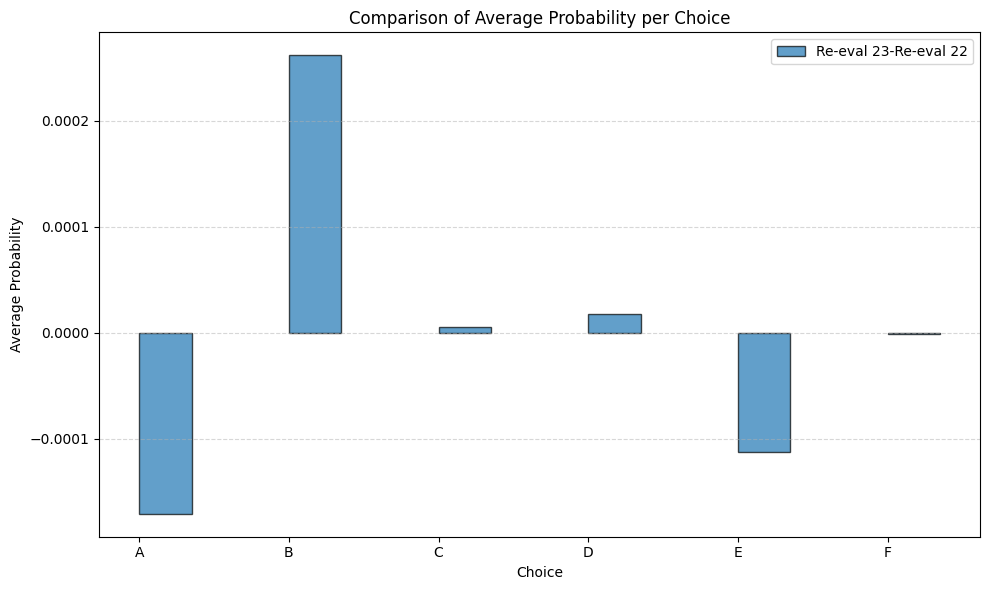

In [133]:
import matplotlib.pyplot as plt
print('-'*10)
x = pd.read_pickle("re_eval_results_23.pkl")
print_evaluation(x)
print('-'*10)
y = pd.read_pickle("re_eval_results_22.pkl")
print_evaluation(y)
print('-'*10)

def plot_avg_prob_comparison(df1, df2, label1='DF1', label2='DF2'):
    """
    Plots a side-by-side histogram of the average probability per choice 
    for two dataframes containing a 'choices_probs' column (dict).
    """
    # Convert list of dicts to DataFrame and calculate mean per column (A, B, C...)
    vals1 = pd.DataFrame(df1['choices_probs'].tolist()).fillna(0)
    vals2 = pd.DataFrame(df2['choices_probs'].tolist()).fillna(0)

    # Convert list of dicts to DataFrame and calculate mean per column (A, B, C...)
    mean1 = vals1.mean()
    mean2 = vals2.mean()
    diff = (vals1 - vals2).mean()
    # Ensure we have the same keys in sorted order
    all_keys = sorted(list(set(mean1.index) | set(mean2.index)))
    mean1 = mean1.reindex(all_keys, fill_value=0)
    mean2 = mean2.reindex(all_keys, fill_value=0)
    
    # Setup plot
    x = np.arange(len(all_keys))
    width = 0.35  # width of the bars
    
    fig, ax = plt.subplots(figsize=(10, 6))
    # rects1 = ax.bar(x - width/2, mean1, width, label=label1, alpha=0.7, edgecolor='black')
    # rects2 = ax.bar(x + width/2, mean2, width, label=label2, alpha=0.7, edgecolor='black')
    rects3 = ax.bar(x + width/2, diff, width, label=f"{label1}-{label2}", alpha=0.7, edgecolor='black')
    
    # Labels and styling
    ax.set_ylabel('Average Probability')
    ax.set_xlabel('Choice')
    ax.set_title('Comparison of Average Probability per Choice')
    ax.set_xticks(x)
    ax.set_xticklabels(all_keys)
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

plot_avg_prob_comparison(x, y, label1='Re-eval 23', label2='Re-eval 22')



In [134]:
import seaborn as sns
from functools import partial

# Convert list of dicts to DataFrame and calculate mean per column (A, B, C...)
vals1 = pd.DataFrame(x['choices_probs'].tolist()).fillna(0)
vals2 = pd.DataFrame(y['choices_probs'].tolist()).fillna(0)

# Convert list of dicts to DataFrame and calculate mean per column (A, B, C...)
mean1 = vals1.mean()
mean2 = vals2.mean()
diff = (vals1 - vals2)
def plot_prob_diff_scatter(df1, df2, label_col='label'):
    """
    Plots a scatter plot of the difference in probability assigned to the TRUE label 
    (df1 - df2) for each row, colored by the label.
    """
    # 1. Extract the probability of the TRUE label for each row in both DFs
    #    We use .get(row[label_col], 0) to handle cases where the label might not be in the dict
    prob1 = df1.apply(lambda row: row['choices_probs'].get(row[label_col], 0), axis=1)
    prob2 = df2.apply(lambda row: row['choices_probs'].get(row[label_col], 0), axis=1)
    
    # 2. Calculate the difference
    diffs = prob1 - prob2
    
    # 3. Create a temporary DataFrame for plotting
    plot_data = pd.DataFrame({
        'Index': range(len(diffs)),
        'Probability Difference (DF1 - DF2)': diffs,
        'Label': df1[label_col]
    })
    
    # 4. Plot
    plt.figure(figsize=(5, 5))
    sns.scatterplot(
        data=plot_data, 
        x='Index', 
        y='Probability Difference (DF1 - DF2)', 
        hue='Label', 
        palette='tab10',
        alpha=0.7
    )
    
    plt.axhline(0, color='gray', linestyle='--', linewidth=1)
    plt.title(f'Difference in True Label Probability per Row (DF1 - DF2)')
    plt.ylabel('Prob Diff (Positive = DF1 is better)')
    plt.xlabel('Sample Index')
    plt.legend()
    plt.tight_layout()
    plt.show()
# plot_prob_diff_scatter(x, y, label_col='label')
diff.max()
def round_vals(v):
    return {k: round(val, 4) for k, val in v.items()}

x['correct'] = x['pred_label'] == x['label']
y['correct'] = y['pred_label'] == y['label']
mask = (x['correct'] == False) & (y['correct'] == True)
vals1=x.loc[ mask, 'choices_probs'].apply(round_vals)
vals2=y.loc[mask, 'choices_probs'].apply(round_vals)
def print_cmp(v1, v2):
    for i in range(len(v1)):
        print(f"{v1.iloc[i]}|{v2.iloc[i]}, True:{x.loc[mask].iloc[i]['label']}")
# print(pd.concat([vals1, vals2], axis=1, keys=['23', '22']))
print_cmp(vals1, vals2)
# print('----'*5)
# print(vals2)

{'A': 0.0025, 'F': 0.9975}|{'A': 0.0031, 'F': 0.9969}, True:F
{'A': 0.03, 'C': 0.0002, 'D': 0.0001, 'E': 0.0002, 'F': 0.9695}|{'A': 0.0235, 'C': 0.0001, 'D': 0.0001, 'E': 0.0002, 'F': 0.9761}, True:F
{'A': 0.0022, 'F': 0.9978}|{'A': 0.003, 'F': 0.997}, True:F
{'A': 0.0016, 'F': 0.9984}|{'A': 0.0026, 'F': 0.9974}, True:F
{'A': 0.0035, 'F': 0.9965}|{'A': 0.0037, 'F': 0.9963}, True:F
{'A': 0.007, 'F': 0.993}|{'A': 0.0105, 'F': 0.9895}, True:F
{'A': 0.0041, 'F': 0.9959}|{'A': 0.0056, 'F': 0.9944}, True:F
{'A': 0.0079, 'F': 0.9921}|{'A': 0.0097, 'F': 0.9903}, True:F
{'A': 0.0223, 'F': 0.9777}|{'A': 0.0299, 'F': 0.9701}, True:F
{'A': 0.0344, 'C': 0.0015, 'E': 0.0002, 'F': 0.9639}|{'A': 0.031, 'C': 0.0007, 'E': 0.0002, 'F': 0.9682}, True:F
{'A': 0.0495, 'D': 0.0005, 'E': 0.0006, 'F': 0.9494}|{'A': 0.0296, 'D': 0.0002, 'E': 0.0004, 'F': 0.9699}, True:F
{'A': 0.571, 'D': 0.0004, 'E': 0.0007, 'F': 0.4278}|{'A': 0.436, 'D': 0.0002, 'E': 0.0008, 'F': 0.5629}, True:F
{'A': 0.0109, 'F': 0.9891}|{'A'

In [167]:
df_shift.iloc[29]['choices_probs']
df_shift.iloc[29]['pred_set']

['A', 'E', 'F']

In [10]:
df_shift = pd.read_pickle("re_eval_results_23.pkl")
# print_evaluation(df_shift)
print('-'*10)
df_orig = pd.read_pickle("re_eval_results_22.pkl")
# print_evaluation(df_orig)

def remap_choice(row):
    label_map = {chr(65 + i): lab for i, lab in enumerate(row['pred_set0'])}
    label = label_map.get(row['pred_label'],row['pred_label'])
    return label
    
choices = test_df[test_df['pred_set_size'] > 1]['pred_set'].tolist()
df_orig['pred_set0'] = choices
df_shift['pred_set0'] = choices
df_shift['pred_label'] = df_shift.apply(remap_choice, axis=1)
df_shift['text_output'] = df_shift.apply(lambda row:f'{row['pred_label']}{row["text_output"][1:]}', axis=1)

df_orig['correct'] = df_orig['pred_label'] == df_orig['label']
df_shift['correct'] = df_shift['pred_label'] == df_shift['label']

mask = df_shift['pred_set0'].apply(len) != df_orig['pred_set0'].apply(len)



# df_shift[df_shift['pred_set0'].apply(len) != df_orig['pred_set0'].apply(len)]

----------


In [216]:
print_evaluation(df_orig)
df_shift['pred_label'] =df_shift.apply(remap_choice, axis=1)
print("After remapping:-------------------")
print_evaluation(df_shift)

Metrics for split: test_task
{'Ele. Acc': np.float64(81.62), 'Op. F1': np.float64(78.84), 'Step SR': np.float64(75.37), 'SR': np.float64(23.12)}
Metrics for split: test_domain
{'Ele. Acc': np.float64(71.19), 'Op. F1': np.float64(68.84), 'Step SR': np.float64(65.83), 'SR': np.float64(17.44)}
Metrics for split: test_website
{'Ele. Acc': np.float64(66.24), 'Op. F1': np.float64(63.84), 'Step SR': np.float64(59.16), 'SR': np.float64(7.81)}
Metrics for overall dataset:
{'Ele. Acc': np.float64(72.33), 'Op. F1': np.float64(69.89), 'Step SR': np.float64(66.57), 'SR': np.float64(17.09)}
After remapping:-------------------
Metrics for split: test_task
{'Ele. Acc': np.float64(81.3), 'Op. F1': np.float64(78.55), 'Step SR': np.float64(75.22), 'SR': np.float64(23.12)}
Metrics for split: test_domain
{'Ele. Acc': np.float64(71.24), 'Op. F1': np.float64(68.91), 'Step SR': np.float64(65.88), 'SR': np.float64(17.6)}
Metrics for split: test_website
{'Ele. Acc': np.float64(66.35), 'Op. F1': np.float64(63.94

In [153]:
df_shift.loc[mask, 'pred_set']

9       [A, B, C, D]
25            [A, F]
51      [A, D, E, F]
115        [A, B, F]
148              [A]
            ...     
5565    [A, B, C, D]
5591          [A, B]
5619       [A, B, C]
5631    [A, B, E, F]
5644       [A, B, C]
Name: pred_set, Length: 436, dtype: object

In [218]:
# df_shift[(df_shift['correct'] == False) & (df_orig['correct'] == True)]
df_shift[ (df_orig['pred_label'] != df_shift['pred_label'])]
np.mean(df_orig['pred_label'] != df_shift['pred_label'])

np.float64(0.003542330853701736)

In [215]:
df_orig[(df_shift['correct'] == False) & (df_orig['correct'] == True)]

,relative_idx,annotation_id,action_uid,pred_label,pred_action,pred_value,label,label_text,choices_probs,prob,test_split,text_output,pred_set0,correct
62,62,a5dd5729-415a-4fe2-a840-4935bf9428d4,22eae06e-b5ac-47b7-83bd-56e50fbe5722,F,CLICK,None,F,F.\nAction: CLICK,"{'A': 0.43603944778442383, 'D': 0.000237909072...",0.562875,0,F. Action: CLICK,"[A, D, E, F]",True
653,668,513f4cef-feaa-45be-818d-75c876830af0,fda61d10-22a6-4b6f-93d4-25dd145258c6,F,CLICK,None,F,F.\nAction: CLICK,"{'A': 0.17705582082271576, 'F': 0.822944223880...",0.822944,0,F. Action: CLICK,"[A, F]",True
985,1007,6b215dbb-a2c4-451c-9c34-9bafe6660c14,7f460a2a-0b5f-4d7c-8d36-38b494090dff,F,TYPE,42701,F,F.\nAction: TYPE\nValue: 42701,"{'A': 0.4450012445449829, 'D': 0.0001559308875...",0.554585,0,F. Action: TYPE Value: 42701,"[A, D, E, F]",True
1110,1137,3594153c-7dbb-40bc-bad9-8c730840ab1a,f3ea5927-f970-4cd8-96e1-71596a1ea9b9,B,CLICK,None,B,B.\nAction: CLICK,"{'A': 0.46973755955696106, 'B': 0.529846847057...",0.529847,0,B. Action: CLICK,"[A, B, D, F]",True
2958,1825,d712a8d1-78e0-4aa7-bb2b-ee7a01105309,1df4405e-0c39-42df-a2ac-ec78276c0046,F,CLICK,None,F,F.\nAction: CLICK,"{'A': 0.4187127649784088, 'B': 0.0002946731401...",0.580573,1,F. Action: CLICK,"[A, B, C, E, F]",True
3466,2347,753bf34d-09a9-4187-b175-6e71fd8d491d,6a23bd49-cdf1-483f-883d-9578a10f03ee,F,CLICK,None,F,F.\nAction: CLICK,"{'A': 0.45042118430137634, 'E': 0.000218317087...",0.549360,1,F. Action: CLICK,"[A, E, F]",True
5024,283,27ada901-d3db-43a6-b53c-c8ad05e80c26,ef3dbf09-e9d7-41b8-a51e-d569f879370e,F,CLICK,None,F,F.\nAction: CLICK,"{'A': 0.4050358235836029, 'C': 0.0018486545886...",0.589454,2,F. Action: CLICK,"[A, C, D, E, F]",True


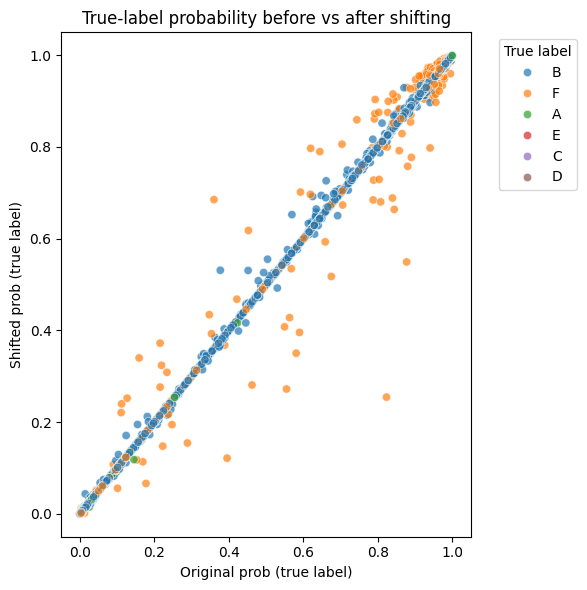

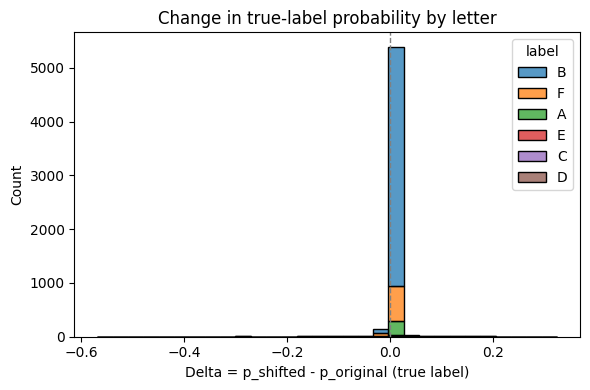

In [208]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Inputs: two DataFrames with per-sample probs
# Assumed columns: annotation_id, action_uid, label (true letter), choices_probs (dict of letter->prob)
# df_orig = pd.read_pickle("re_eval_results_22.pkl")          # original evaluation (e.g., A,B,F)
# df_shift = pd.read_pickle("re_eval_results_23.pkl")    # shifted/renamed choices (e.g., A,B,C mapped from A,B,F)

# Merge on a unique key; adjust keys if you use a different identifier
key_cols = ["annotation_id", "action_uid"]
merged = df_orig[key_cols + ["label", "choices_probs"]].merge(
    df_shift[key_cols + ["choices_probs"]],
    on=key_cols,
    suffixes=("_orig", "_shift")
)

# Extract probabilities for the true label from both runs
merged["p_orig"] = merged.apply(lambda r: r["choices_probs_orig"].get(r["label"], 0.0), axis=1)
merged["p_shift"] = merged.apply(lambda r: r["choices_probs_shift"].get(r["label"], 0.0), axis=1)
merged["delta"] = merged["p_shift"] - merged["p_orig"]

# Scatter: original vs shifted probability for the true label
plt.figure(figsize=(6, 6))
ax = sns.scatterplot(
    data=merged,
    x="p_orig",
    y="p_shift",
    hue="label",  # color by true letter A–F
    palette="tab10",
    alpha=0.7,
)
ax.plot([0, 1], [0, 1], "--", color="gray", linewidth=1)
ax.set_xlabel("Original prob (true label)")
ax.set_ylabel("Shifted prob (true label)")
ax.set_title("True-label probability before vs after shifting")
ax.legend(title="True label", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()

# Delta distribution by letter
plt.figure(figsize=(6, 4))
sns.histplot(data=merged, x="delta", hue="label", multiple="stack", bins=30, palette="tab10")
plt.axvline(0, color="gray", linestyle="--", linewidth=1)
plt.xlabel("Delta = p_shifted - p_original (true label)")
plt.title("Change in true-label probability by letter")
plt.tight_layout()

plt.show()


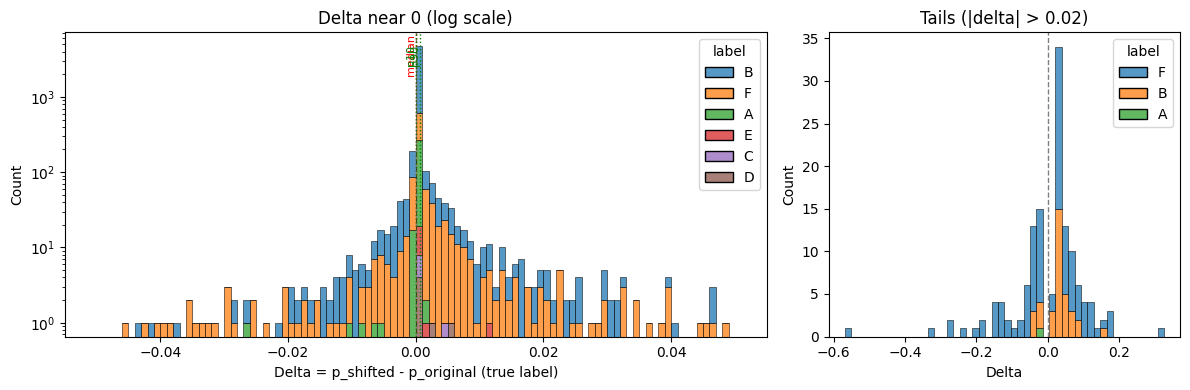

In [209]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# assumes `merged` already has `delta` and `label` columns
eps = 1e-6
merged["delta_clipped"] = merged["delta"].clip(-0.6, 0.6)

fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={"width_ratios": [2, 1]})

# Panel 1: near-zero, log-counts to see tiny shifts
sns.histplot(
    data=merged,
    x="delta_clipped",
    hue="label",
    bins=100,
    binrange=(-0.05, 0.05),
    multiple="stack",
    ax=axes[0],
)
axes[0].set_yscale("log")
axes[0].set_title("Delta near 0 (log scale)")
axes[0].set_xlabel("Delta = p_shifted - p_original (true label)")
axes[0].axvline(0, color="gray", linestyle="--", linewidth=1)

# Panel 2: tails only
sns.histplot(
    data=merged[(merged["delta_clipped"].abs() > 0.02)],
    x="delta_clipped",
    hue="label",
    bins=50,
    multiple="stack",
    ax=axes[1],
)
axes[1].set_title("Tails (|delta| > 0.02)")
axes[1].set_xlabel("Delta")
axes[1].axvline(0, color="gray", linestyle="--", linewidth=1)

# Optional: annotate medians/quantiles on panel 1
med = merged["delta"].median()
q10, q90 = merged["delta"].quantile([0.1, 0.9])
for v, c, lbl in [(med, "red", "median"), (q10, "green", "p10"), (q90, "green", "p90")]:
    axes[0].axvline(v, color=c, linestyle=":", linewidth=1)
    axes[0].text(v, axes[0].get_ylim()[1]*0.5, lbl, rotation=90, va="center", ha="right", color=c, fontsize=8)

plt.tight_layout()
plt.show()


In [220]:
df_shift[df_shift['pred_label'] != df_orig['pred_label']]
# sum(df_shift['pred_label'].isna())
# df_shift[df_shift['pred_label'].isna()]
df_shift[(df_shift['pred_label'] == 'F') & (df_orig['pred_label'] == 'C')]

,relative_idx,annotation_id,action_uid,pred_label,pred_action,pred_value,label,label_text,choices_probs,prob,test_split,text_output,pred_set0,correct
4798,53,be3b849b-8a4f-42ea-be6b-31a586883552,d55abc48-8493-46e6-ad03-5f0428f8b729,F,CLICK,None,A,A.,"{'A': 0.11819154024124146, 'C': 0.881503641605...",0.0,2,C. Action: CLICK,"[A, C, F]",False


In [221]:
df_orig[(df_shift['pred_label'] == 'F') & (df_orig['pred_label'] == 'C')]

,relative_idx,annotation_id,action_uid,pred_label,pred_action,pred_value,label,label_text,choices_probs,prob,test_split,text_output,pred_set0,correct
4798,53,be3b849b-8a4f-42ea-be6b-31a586883552,d55abc48-8493-46e6-ad03-5f0428f8b729,C,CLICK,None,A,A.,"{'A': 0.1451079249382019, 'C': 0.8545677661895...",0.854568,2,C. Action: CLICK,"[A, C, F]",False


Changed predictions: 0.003542330853701736


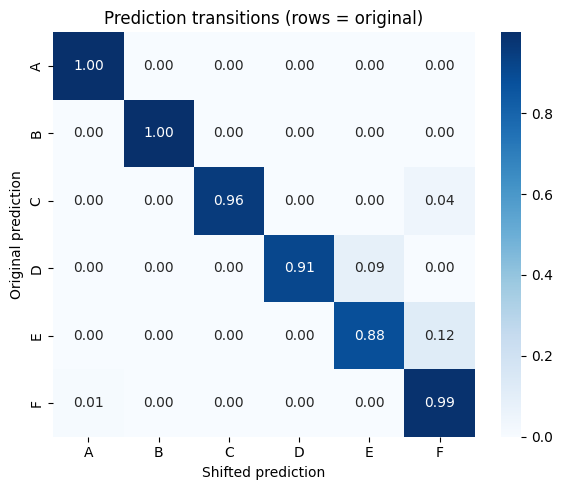

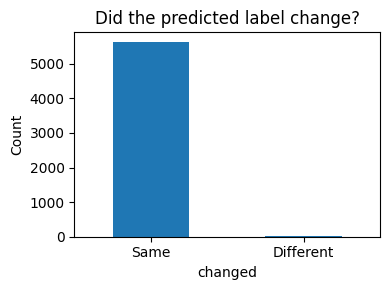

In [219]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Inputs: df_orig and df_shift with the same keys, each having a column `pred_label`
key_cols = ["annotation_id", "action_uid"]  # adjust if you use a different key
merged = df_orig[key_cols + ["pred_label"]].merge(
    df_shift[key_cols + ["pred_label"]],
    on=key_cols,
    suffixes=("_orig", "_shift"),
)

# Flag changed predictions
merged["changed"] = merged["pred_label_orig"] != merged["pred_label_shift"]

# Overall change rate
print("Changed predictions:", merged["changed"].mean())

# Transition matrix: how original preds map to shifted preds
trans = pd.crosstab(
    merged["pred_label_orig"],
    merged["pred_label_shift"],
    normalize="index",  # rows sum to 1
)

plt.figure(figsize=(6, 5))
sns.heatmap(trans, annot=True, fmt=".2f", cmap="Blues")
plt.xlabel("Shifted prediction")
plt.ylabel("Original prediction")
plt.title("Prediction transitions (rows = original)")
plt.tight_layout()

# Optional: bar showing changed vs unchanged counts
plt.figure(figsize=(4, 3))
merged["changed"].value_counts().reindex([False, True]).plot(kind="bar")
plt.xticks([0, 1], ["Same", "Different"], rotation=0)
plt.ylabel("Count")
plt.title("Did the predicted label change?")
plt.tight_layout()
plt.show()


In [131]:
mask = (df_orig['pred_label'] == 'F')&(df_shift['pred_label'] != 'F')
cols = ['pred_label']
merge = pd.concat([df_orig.loc[mask,cols], df_shift.loc[mask,cols + ['label']]], axis=1, keys=['orig','shift'])
# df_orig.loc[mask, ['choices_probs', 'pred_label']]
# merge
j = 32
x=df_orig.iloc[j].apply(lambda x: x if not isinstance(x, dict) else {k: round(v,4) for k,v in x.items()})
y=df_shift.iloc[j].apply(lambda x: x if not isinstance(x, dict) else {k: round(v,4) for k,v in x.items()})
# print(x)
# print(y)
# df_shift['pred_set'] = df_shift['choices_probs'].apply(lambda row: [ label for label, prob in row.items() if 1 - prob <= threshold])

df_shift = pd.read_pickle("re_eval_results_23.pkl")
df_shift['pred_set'] = df_shift['choices_probs'].apply(lambda row: [ label for label, prob in row.items() if 1 - prob <= threshold])
# df_orig['pred_set'] = df_orig['choices_probs'].apply(lambda row: [ label for label, prob in row.items() if 1 - prob <= threshold])

def remap_choice(row):
    label_map = {chr(65 + i): lab for i, lab in enumerate(row['pred_set'])}
    label = label_map.get(row['pred_label'],row['pred_label'])
    if label is None:
        print(f"Warning: pred_label {row['pred_label']} not in pred_set {row['pred_set']},map: {label_map}")
    return label

df_shift['pred_label'] = df_shift.apply(remap_choice, axis=1)
df_shift['correct'] = df_shift['pred_label'] == df_shift['label']
df_orig['correct'] = df_orig['pred_label'] == df_orig['label']
mask = df_shift['pred_label']!= df_orig['pred_label']
df_shift.loc[mask]['pred_label'] + ' ' + df_orig.loc[mask]['pred_label']
np.mean(df_shift['pred_label'] != df_orig['pred_label'])
np.mean(df_shift.loc[mask,"correct"])
np.mean(df_orig.loc[mask,"correct"])

np.float64(0.8507462686567164)

In [103]:
df_shift[['pred_label', 'pred_label']].count(axis=1)

0       2
1       2
2       2
3       2
4       2
       ..
5641    2
5642    2
5643    2
5644    2
5645    2
Length: 5646, dtype: int64

In [133]:
test_df[(test_df['pred_set_size'] > 1)]['pred_label'].value_counts()
# print_evaluation(test_df[(test_df['pred_set_size'] > 1)])
target_df = test_df[(test_df['pred_set_size'] > 1)]
# re_eval_df['correct'] = re_eval_df['pred_label'] == re_eval_df['label']
re_eval_df[(re_eval_df['correct'] == False)*(re_eval_df['choices_probs'].apply(len) < 3 ) ]

,relative_idx,annotation_id,action_uid,pred_label,pred_action,pred_value,label,label_text,choices_probs,prob,test_split,text_output,correct
61,61,a5dd5729-415a-4fe2-a840-4935bf9428d4,6f0fbffd-7b9a-4617-8ca0-dfe09d17fe84,A,None,None,B,B.\nAction: CLICK,"{'A': 0.97406005859375, 'B': 0.02440628781914711}",0.974060,0,A.,False
66,66,a2500e0b-9244-4f0e-b686-fa290c32b829,6c8dd194-8f21-40d5-965f-16f830080a9f,A,None,None,B,B.\nAction: CLICK,"{'A': 0.5458950400352478, 'B': 0.4510578215122...",0.545895,0,A.,False
100,101,c52fcdf7-1f23-4074-91bb-1a121af02a80,c4002058-d0c6-4345-b898-2e9f1d08a1d9,A,None,None,B,B.\nAction: CLICK,"{'A': 0.7016181349754333, 'B': 0.2920215725898...",0.701618,0,A.,False
118,119,4b8fb0aa-7d7c-4a22-bfd5-f09316a050c3,5eb1b7b7-713b-4401-b3ae-82972018bf46,A,None,None,B,B.\nAction: TYPE\nValue: chicago,"{'A': 0.5183804631233215, 'B': 0.477065771818161}",0.518380,0,A.,False
151,153,18fc60d7-aa69-4c07-9bf1-64543eae52c9,d5183310-fdfb-4274-b913-0399ca060327,A,None,None,F,F.\nAction: CLICK,"{'A': 0.7999187707901001, 'F': 0.1928970217704...",0.799919,0,A.,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5387,651,a1b36184-1ae4-45fb-aa6a-b892d38ac771,cede5a17-3d73-4a78-abd4-28c93edaf0b4,A,None,None,B,B.\nAction: CLICK,"{'A': 0.8428732752799988, 'B': 0.1511935293674...",0.842873,2,A.,False
5421,685,aa835369-48e5-4e8f-8f36-49dcdaf5dcb1,3676f8c8-5054-42c7-bbac-f0df9a0a6413,A,None,None,B,B.\nAction: CLICK,"{'A': 0.9769367575645447, 'B': 0.0204986240714...",0.976937,2,A.,False
5432,696,b5b427a3-2a23-4847-af06-351d96e11c27,8b602827-65cb-401d-ad0e-e7ac11b66555,A,None,None,B,B.\nAction: CLICK,"{'A': 0.9989016056060791, 'B': 0.0004397292213...",0.998902,2,A.,False
5462,727,baf8a9d8-1788-4599-a9a9-dd22b619dcbf,265ecc26-5c87-4260-8286-56883ab57c6b,A,None,None,B,B.\nAction: CLICK,"{'A': 0.9930604696273804, 'B': 0.0032687948551...",0.993060,2,A.,False


NameError: name 'df_shifted' is not defined

In [ ]:
re_eval_df = pd.read_pickle("re_eval_results_22.pkl")
df_all = pd.concat([test_df[test_df['pred_set_size'] == 1], re_eval_df], ignore_index=True)

,relative_idx,annotation_id,action_uid,pred_label,pred_action,pred_value,label,label_text,choices_probs,prob,test_split,text_output,correct
12,12,91695df8-f256-47c9-8c37-06e8d0fc758f,f425232b-adc6-4047-b3ac-d56d8909b7df,A,None,None,B,B.\nAction: TYPE\nValue: 2,"{'A': 0.9711814522743225, 'B': 0.0267420373857...",0.971181,0,A.,False
25,25,9223f1b4-43ad-4636-9541-99ff9e6ad918,306d45f6-fbd1-497f-9272-8ac36e680dfb,A,None,None,F,F.\nAction: CLICK,"{'A': 0.9984234571456909, 'B': 0.0001089646175...",0.998423,0,A.,False
26,26,9223f1b4-43ad-4636-9541-99ff9e6ad918,37a912ac-ce6b-49e6-a217-bca2ec8dc56b,A,None,None,F,F.\nAction: CLICK,"{'A': 0.9975793957710266, 'B': 0.0002460335381...",0.997579,0,A.,False
28,28,9223f1b4-43ad-4636-9541-99ff9e6ad918,799e7c53-787c-4e67-a6a5-0e69d11898ca,A,None,None,F,F.\nAction: CLICK,"{'A': 0.9880466461181641, 'B': 0.0005599322612...",0.988047,0,A.,False
31,31,9223f1b4-43ad-4636-9541-99ff9e6ad918,8fd603de-4f5a-412b-b2d4-d6e9537a9ce3,A,None,None,F,F.\nAction: TYPE\nValue: 10/5/23,"{'A': 0.9194322824478149, 'B': 0.0003742944390...",0.919432,0,A.,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5632,901,924476f8-37f9-42e2-bedf-64eeac0ce8b6,6b819181-7e0e-4931-a80a-ba865efddc47,A,None,None,F,F.\nAction: CLICK,"{'A': 0.7329919934272766, 'B': 0.0016496684402...",0.732992,2,A.,False
5633,902,924476f8-37f9-42e2-bedf-64eeac0ce8b6,1675d403-9653-40c0-8663-e32e551e762d,A,None,None,F,F.\nAction: CLICK,"{'A': 0.9444356560707092, 'B': 0.0017172939842...",0.944436,2,A.,False
5634,903,924476f8-37f9-42e2-bedf-64eeac0ce8b6,d0d06095-d269-49a6-b441-81cf2b243cf8,A,None,None,F,F.\nAction: CLICK,"{'A': 0.910167932510376, 'B': 0.00160806765779...",0.910168,2,A.,False
5635,904,924476f8-37f9-42e2-bedf-64eeac0ce8b6,dfaf20bb-0e0a-4791-8189-c80f72029c13,A,None,None,F,F.\nAction: CLICK,"{'A': 0.8849900364875793, 'B': 0.0015113170957...",0.884990,2,A.,False


In [36]:
re_eval_df = pd.read_pickle("re_eval_results2.pkl")
df_all = pd.concat([test_df[test_df['pred_set_size'] == 1], re_eval_df], ignore_index=True)
# re_eval_df['correct'] = re_eval_df['pred_label'] == re_eval_df['label']
# re_eval_df['pred_label'].value_counts()
print_evaluation(df_all)

Metrics for split: test_task
{'Ele. Acc': np.float64(80.11), 'Op. F1': np.float64(77.22), 'Step SR': np.float64(74.24), 'SR': np.float64(21.88)}
Metrics for split: test_domain
{'Ele. Acc': np.float64(69.74), 'Op. F1': np.float64(67.21), 'Step SR': np.float64(64.43), 'SR': np.float64(16.64)}
Metrics for split: test_website
{'Ele. Acc': np.float64(65.59), 'Op. F1': np.float64(63.18), 'Step SR': np.float64(58.47), 'SR': np.float64(7.81)}
Metrics for overall dataset:
{'Ele. Acc': np.float64(70.97), 'Op. F1': np.float64(68.4), 'Step SR': np.float64(65.31), 'SR': np.float64(16.32)}


In [22]:
print_evaluation(test_df[test_df['pred_set_size'] > 1])

Metrics for split: test_task
{'Ele. Acc': np.float64(82.28), 'Op. F1': np.float64(79.68), 'Step SR': np.float64(76.3), 'SR': np.float64(23.12)}
Metrics for split: test_domain
{'Ele. Acc': np.float64(72.82), 'Op. F1': np.float64(70.34), 'Step SR': np.float64(67.27), 'SR': np.float64(16.48)}
Metrics for split: test_website
{'Ele. Acc': np.float64(69.61), 'Op. F1': np.float64(67.19), 'Step SR': np.float64(62.67), 'SR': np.float64(8.59)}
Metrics for overall dataset:
{'Ele. Acc': np.float64(74.03), 'Op. F1': np.float64(71.53), 'Step SR': np.float64(68.21), 'SR': np.float64(16.54)}


In [ ]:
# re_eval_df = pd.read_pickle("re_eval_results2.pkl")
print_evaluation(re_eval_df)

x=re_eval_df['choices_probs'].apply(len)
# re_eval_df[x > 3]['choices_probs'].apply(lambda x: x.keys())


Metrics for split: test_task
{'Ele. Acc': np.float64(80.11), 'Op. F1': np.float64(77.22), 'Step SR': np.float64(74.24), 'SR': np.float64(21.88)}
Metrics for split: test_domain
{'Ele. Acc': np.float64(69.81), 'Op. F1': np.float64(67.29), 'Step SR': np.float64(64.5), 'SR': np.float64(16.96)}
Metrics for split: test_website
{'Ele. Acc': np.float64(65.59), 'Op. F1': np.float64(63.18), 'Step SR': np.float64(58.47), 'SR': np.float64(7.81)}
Metrics for overall dataset:
{'Ele. Acc': np.float64(71.02), 'Op. F1': np.float64(68.45), 'Step SR': np.float64(65.36), 'SR': np.float64(16.54)}


0          (A, B, C, E, F)
9          (A, B, C, D, F)
11         (A, B, C, D, F)
12            (A, B, D, F)
13            (A, B, C, F)
               ...        
5634    (A, B, C, D, E, F)
5635    (A, B, C, D, E, F)
5638          (A, B, C, F)
5644          (A, B, C, F)
5645    (A, B, C, D, E, F)
Name: choices_probs, Length: 2268, dtype: object

In [24]:
re_eval_df = pd.read_pickle("re_eval_results4.pkl")
re_eval_df['correct'] = re_eval_df['pred_label'] == re_eval_df['label']
print_evaluation(re_eval_df)

Metrics for split: test_task
{'Ele. Acc': np.float64(64.18), 'Op. F1': np.float64(61.18), 'Step SR': np.float64(58.57), 'SR': np.float64(10.0)}
Metrics for split: test_domain
{'Ele. Acc': np.float64(56.63), 'Op. F1': np.float64(55.05), 'Step SR': np.float64(52.39), 'SR': np.float64(8.96)}
Metrics for split: test_website
{'Ele. Acc': np.float64(53.74), 'Op. F1': np.float64(51.87), 'Step SR': np.float64(47.33), 'SR': np.float64(6.25)}
Metrics for overall dataset:
{'Ele. Acc': np.float64(57.55), 'Op. F1': np.float64(55.68), 'Step SR': np.float64(52.76), 'SR': np.float64(8.76)}


In [50]:
print_evaluation(test_df[test_df['pred_set_size'] > 1])

Metrics for split: test_task
{'Ele. Acc': np.float64(82.28), 'Op. F1': np.float64(79.68), 'Step SR': np.float64(76.3), 'SR': np.float64(23.12)}
Metrics for split: test_domain
{'Ele. Acc': np.float64(72.82), 'Op. F1': np.float64(70.34), 'Step SR': np.float64(67.27), 'SR': np.float64(16.48)}
Metrics for split: test_website
{'Ele. Acc': np.float64(69.61), 'Op. F1': np.float64(67.19), 'Step SR': np.float64(62.67), 'SR': np.float64(8.59)}
Metrics for overall dataset:
{'Ele. Acc': np.float64(74.03), 'Op. F1': np.float64(71.53), 'Step SR': np.float64(68.21), 'SR': np.float64(16.54)}


In [75]:
print_evaluation(re_eval_df)

Metrics for split: test_task
{'Ele. Acc': np.float64(64.18), 'Op. F1': np.float64(61.18), 'Step SR': np.float64(58.57), 'SR': np.float64(10.0)}
Metrics for split: test_domain
{'Ele. Acc': np.float64(56.63), 'Op. F1': np.float64(55.05), 'Step SR': np.float64(52.39), 'SR': np.float64(8.96)}
Metrics for split: test_website
{'Ele. Acc': np.float64(53.74), 'Op. F1': np.float64(51.87), 'Step SR': np.float64(47.33), 'SR': np.float64(6.25)}
Metrics for overall dataset:
{'Ele. Acc': np.float64(57.55), 'Op. F1': np.float64(55.68), 'Step SR': np.float64(52.76), 'SR': np.float64(8.76)}


In [ ]:
Metrics for split: test_task
{'Ele. Acc': np.float64(79.45), 'Op. F1': np.float64(80.77), 'Step SR': np.float64(73.46), 'SR': np.float64(20.0)}
Metrics for split: test_domain
{'Ele. Acc': np.float64(68.85), 'Op. F1': np.float64(71.84), 'Step SR': np.float64(63.59), 'SR': np.float64(14.24)}
Metrics for split: test_website
{'Ele. Acc': np.float64(65.04), 'Op. F1': np.float64(67.99), 'Step SR': np.float64(57.93), 'SR': np.float64(7.03)}
Metrics for overall dataset:
{'Ele. Acc': np.float64(70.17), 'Op. F1': np.float64(72.87), 'Step SR': np.float64(64.53), 'SR': np.float64(14.24)}

In [60]:
print_evaluation(re_eval_df)

Metrics for split: test_task
{'Ele. Acc': np.float64(62.52), 'Op. F1': np.float64(59.8), 'Step SR': np.float64(57.15), 'SR': np.float64(10.0)}
Metrics for split: test_domain
{'Ele. Acc': np.float64(55.88), 'Op. F1': np.float64(54.31), 'Step SR': np.float64(51.72), 'SR': np.float64(8.48)}
Metrics for split: test_website
{'Ele. Acc': np.float64(52.99), 'Op. F1': np.float64(51.0), 'Step SR': np.float64(46.93), 'SR': np.float64(4.69)}
Metrics for overall dataset:
{'Ele. Acc': np.float64(56.64), 'Op. F1': np.float64(54.81), 'Step SR': np.float64(52.0), 'SR': np.float64(8.21)}


In [47]:
test_df[(test_df_merged["correct"] == False)&(test_df["correct"] == True)]['pred_label'].value_counts()

pred_label
B    238
F     49
A      3
D      1
Name: count, dtype: int64

In [39]:
answer = answer_df.iloc[37]
print(answer['annotation_id'],'|' ,answer['action_uid'])
print(answer['oracle_answer'])

a52fcf7a-50aa-4256-8796-654b3dc3adac | f78348d5-7bb5-4175-961c-4facb4dff324
Click the "Tickets & Passes" link located in the navigation menu, which is labeled with the text "Tickets & Pass


In [46]:
test_df_merged['correct'] = test_df_merged['pred_label'] == test_df_merged['label']
test_df_merged[(test_df_merged["correct"] == False)&(test_df["correct"] == True)]['pred_label'].value_counts()

pred_label
A    283
E      3
C      3
B      2
Name: count, dtype: int64

In [24]:
re_eval_df = pd.read_pickle("re_eval_results.pkl")
test_df_copy = pd.read_pickle("test_results.pkl")
# keys that identify a row
merge_keys = ["annotation_id", "action_uid"]

# align indexes for update
re_eval_aligned = re_eval_df.set_index(merge_keys)
test_df_aligned = test_df_copy.set_index(merge_keys)

# overwrite existing cols where re-eval has data
test_df_aligned.update(re_eval_aligned)

# back to a regular DataFrame
test_df_merged = test_df_aligned.reset_index()
test_df_merged.head()

,annotation_id,action_uid,relative_idx,pred_label,pred_action,pred_value,label,label_text,choices_probs,prob,test_split,labels_tokens
0,91695df8-f256-47c9-8c37-06e8d0fc758f,73e0e7ed-d784-4b7a-a06c-48324e44ce7b,0,B,CLICK,None,B,B.\nAction: CLICK,"{'A': 0.025247467681765556, 'B': 0.97417777776...",0.974178,0,B.\nAction: CLICK\n
1,91695df8-f256-47c9-8c37-06e8d0fc758f,ea2865e4-2858-478c-bf83-93d576cad774,1,B,CLICK,None,B,B.\nAction: CLICK,"{'A': 0.0035883907694369555, 'B': 0.9961434006...",0.996143,0,B.\nAction: CLICK\n
2,91695df8-f256-47c9-8c37-06e8d0fc758f,c70a5d9b-8777-4ff7-a17d-1f76012e14ba,2,B,TYPE,08817,B,B.\nAction: TYPE\nValue: 08817,"{'A': 0.012266379781067371, 'B': 0.98672604560...",0.986726,0,B.\nAction: TYPE\nValue: 08817
3,91695df8-f256-47c9-8c37-06e8d0fc758f,3e671043-cab2-4e44-a1ce-3ed9de91d16b,3,B,CLICK,None,B,B.\nAction: CLICK,"{'A': 0.02020300179719925, 'B': 0.978624403476...",0.978624,0,B.\nAction: CLICK\n
4,91695df8-f256-47c9-8c37-06e8d0fc758f,60888ab2-b605-4886-8dac-6ba72b6cde0a,4,B,CLICK,None,B,B.\nAction: CLICK,"{'A': 0.006945854984223843, 'B': 0.99270260334...",0.992703,0,B.\nAction: CLICK\n


In [32]:
len(test_df)

5799

In [33]:
len(test_df_merged)

5799

In [25]:
test_df_copy[test_df["pred_set_size"] > 1] = re_eval_df
test_df_copy.head()

,relative_idx,annotation_id,action_uid,pred_label,pred_action,pred_value,label,label_text,choices_probs,prob,test_split,labels_tokens
0,0.0,91695df8-f256-47c9-8c37-06e8d0fc758f,73e0e7ed-d784-4b7a-a06c-48324e44ce7b,B,CLICK,None,B,B.\nAction: CLICK,"{'A': 0.025247467681765556, 'B': 0.97417777776...",0.974178,0.0,B. Action: CLICK
1,1.0,91695df8-f256-47c9-8c37-06e8d0fc758f,ea2865e4-2858-478c-bf83-93d576cad774,B,CLICK,None,B,B.\nAction: CLICK,"{'A': 0.0035883907694369555, 'B': 0.9961434006...",0.996143,0.0,B. Action: CLICK
2,2.0,91695df8-f256-47c9-8c37-06e8d0fc758f,c70a5d9b-8777-4ff7-a17d-1f76012e14ba,B,TYPE,08817,B,B.\nAction: TYPE\nValue: 08817,"{'A': 0.012266379781067371, 'B': 0.98672604560...",0.986726,0.0,B. Action: TYPE Value: 08817
3,3.0,91695df8-f256-47c9-8c37-06e8d0fc758f,3e671043-cab2-4e44-a1ce-3ed9de91d16b,B,CLICK,None,B,B.\nAction: CLICK,"{'A': 0.02020300179719925, 'B': 0.978624403476...",0.978624,0.0,B. Action: CLICK
4,4.0,91695df8-f256-47c9-8c37-06e8d0fc758f,60888ab2-b605-4886-8dac-6ba72b6cde0a,B,CLICK,None,B,B.\nAction: CLICK,"{'A': 0.006945854984223843, 'B': 0.99270260334...",0.992703,0.0,B. Action: CLICK


In [ ]:
# gc.collect()         
# torch.cuda.empty_cache()       
# torch.cuda.ipc_collect()
from torch.nn import functional as F


example = test_df[test_df['correct'] != True].iloc[bad_index]
print(example[['pred_label','pred_action','pred_value', 'label_text','choices_probs', 'pred_set']])


print(choices_probs)
print([lab for lab, p in choices_probs.items() if 1 - p <= threshold])

251 110
B. Action: CLICK 
-----
pred_label                                                       A
pred_action                                                   None
pred_value                                                    None
label_text                                       B.\nAction: CLICK
choices_probs    {'A': 0.9799697995185852, 'B': 0.0166981853544...
pred_set                                        [A, B, C, D, E, F]
Name: 112, dtype: object
{'A': 0.025247544050216675, 'B': 0.9741799235343933, 'C': 0.00011176805128343403, 'D': 0.0001968987926375121, 'E': 5.2311141189420596e-05, 'F': 0.000123833044199273}
['A', 'B', 'D']


In [162]:
def temp(d):
    d = {'b':3}

temp_dict = {'a':2}
temp(temp_dict)
temp_dict

{'a': 2}

In [ ]:
A.
-----
pred_label                                                       A
pred_action                                                   None
pred_value                                                    None
label_text                                       F.\nAction: CLICK
choices_probs    {'A': 0.9988712668418884, 'B': 0.0001807211519...
pred_set                                              [A, B, E, F]
Name: 25, dtype: object
{'A': 0.9989086389541626, 'B': 0.00012537989823613316, 'E': 0.0001505803084000945, 'F': 0.0003164380614180118}
['A', 'F']

np.int64(29)

In [ ]:

print(html)
print(rest)

<html> <body> <iframe fb:page facebook social plugin f22569b367eaa4> <div feed> <div> <div> <div> Ticket Center </div> <a id=0> <span> about 6 years ago </span> </a> </div> <div id=1> <p id=2> Jeff Dunham is making everyone laugh with those puppets of his. Haven't seen him live yet? No worries... grab your </p> <a id=3> http://www.ticketcenter.com//perfectly-unbalanced-jeff-du/ </a> </div> </div> </div> </iframe> <tr> <th> Jul 2023 </th> <i id=4 /> </tr> </body> </html>
Based on the HTML webpage above, try to complete the following task:
Task: Browse the venues that are playing the Wicked show from Oct 5 to Oct 24 2023
Previous actions:
[textbox]  Search for artists, teams or venues... -> TYPE: Wicked
[option]  Wicked -> CLICK
[button]  All dates -> CLICK
[textbox]  Select Date Range -> CLICK
[columnheader]   -> CLICK

guidence: None of the provided options are relevant to browsing venues for the Wicked show from Oct 5 to Oct 24,
What should be the next action? Please select from the 

In [ ]:
"""
user

### ROLE
You are a helpful human annotator assisting a web navigation agent. The agent is confused and has narrowed down the next step to a few likely options, but it cannot distinguish which one is correct.
### USER TASK
Rent a truck with the lowest rent with two dozen furniture pads for 100 miles at zip 08817 on April 12 at 2:30 pm rented truck is to be returned to the exact location and date, and the pickup and drop off will be at the nearest location.
Previous Actions: 
[button]  Reservations -> HOVER
[link]  Budget Truck -> CLICK
[textbox]  US City,State or Zip Code -> TYPE: 08817
[textbox]  mm/dd/yyyy -> CLICK
[link]  12 -> CLICK
[select]  Select Pick-up Time -> SELECT: 02:30 PM
[input]   -> CLICK
[button]  Find Your Truck -> CLICK
[button]  Select Truck -> CLICK
[input]   -> TYPE: 100
[button]  Continue to Location  -> CLICK
[button]  Select Pick-up Location -> CLICK


### HTML CONTEXT
<html> <div> <div> <a choose your add-ons /> <input id=0 text 0 /> <a choose your add-ons /> </div> <ul id=1> <li id=2> <a id=3 reservations> Reservations </a> </li> <li id=4> <a commercial rental add-ons> Commercial Rental Add-ons </a> </li> <a commercial account> Commercial Account </a> </ul> </div> </html>

### AVAILABLE OPTIONS
The smaller model has provided the following possible actions:
A. None of the above
B. <input id=0 text 0 />
C. <ul id=1> <li id=2> <a id=3 reservations> Reservations </a> </li>
D. <li id=2> <a id=3 reservations> Reservations </a> </li>
E. <a id=3 reservations> Reservations </a>
F. <li id=4> <a commercial rental add-ons> Commercial Rental Add-ons </a>


### THE AMBIGUOUS OPTIONS (Prediction Set)
The correct action is very likely one of the following. Analyze them carefully:
['A', 'B', 'D', 'F']

### INSTRUCTIONS
1. Analyze the User Task and the HTML Context (and the screenshot if available).
2. Identify the single correct element from the Prediction Set options above.
3. Formulate a natural language instruction to guide the agent to that specific element.
4. **Crucial:** Your instruction must be "Discriminative". Mention specific text labels, icons, or the location of the element to help the agent separate it from the other options.

### RESPONSE FORMAT
Provide your response as a direct command to the agent. 
- If the action is clicking, describe exactly what to click.
- If the action is typing, specify exactly what to type and where.

Example 1 (Click): "Click the 'Menu' button found in the top-left navigation bar."
Example 2 (Type): "Type 'The Matrix' into the search bar located in the header."
Example 3 (Select): "Select 'Price: Low to High' from the dropdown menu."

Your Response:  

assistant
Click the input field labeled "0" under the "Furniture Pad" add-on section to set the quantity to two dozen.
"""

In [22]:
del oracle
gc.collect()         
torch.cuda.empty_cache()       
torch.cuda.ipc_collect()

In [ ]:
# df = pd.DataFrame(test_task_ds)
# len(df.groupby("annotation_id"))
# subsample[0]['action_reprs']

# test_domain_ds = ds['test_domain']
# test_task_ds = ds['test_task']
# test_website_ds = ds['test_website']
count = 0
missing_count = 0
mulit = {}
missing = {}
for i, x in enumerate(test_dict['test_website'].data):
    if len(x['pos_candidates']) > 1:
        count += 1
        mulit[i] = x['annotation_id']
    if len(x['pos_candidates']) == 0:
        # print('Missing pos_candidates:', x['annotation_id'])
        missing_count += 1
        missing[i] = x['annotation_id']

print("Number of samples with multiple positive candidates in test_website:", count)
print("Number of samples with missing positive candidates in test_website:", missing_count)